In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy import moveaxis


generator_input_size = 196608

(256, 256, 3)


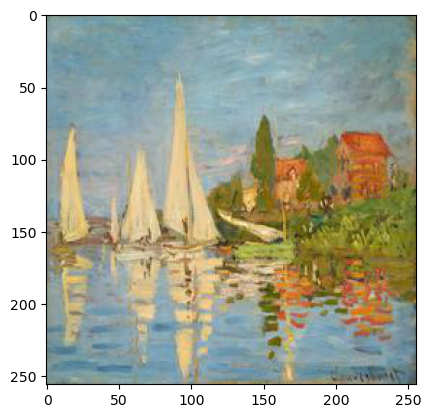

In [2]:
monet_path = "/Users/shuhunglin/Desktop/kaggle/gan-getting-started/monet_jpg"
monet_image = plt.imread(monet_path+"/"+next(iter(os.listdir(monet_path))))
print(monet_image.shape)
plt.imshow(monet_image)

In [3]:
monet_image_size = monet_image.shape

In [4]:
monet_image_size

(256, 256, 3)

In [5]:
monet_images = []
for image in os.listdir(monet_path):
    image = plt.imread(monet_path+"/"+image)
    monet_images.append(moveaxis(image,-1,0))
monet_images = np.array(monet_images)
print(monet_images.shape)
# vector_size = monet_images[0].shape

(300, 3, 256, 256)


In [6]:
# image_mean = monet_images.mean(axis = 0)
# image_std = monet_images.std(axis = 0)
# standardized_image = (monet_images - image_mean)/image_std

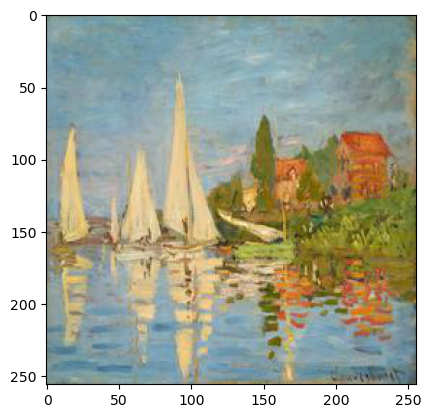

In [7]:
plt.imshow(moveaxis(monet_images[0],0,-1))

In [8]:
def noise(size):
    return np.random.normal(size = (size,generator_input_size)).astype(np.float32)

In [9]:
photo_path = "/Users/shuhunglin/Desktop/kaggle/gan-getting-started/photo_jpg"
real_images = []
for image in os.listdir(photo_path):
    image = plt.imread(photo_path+"/"+image)
    real_images.append(moveaxis(image,-1,0))
real_images = np.array(real_images)
print(real_images.shape)

(7038, 3, 256, 256)


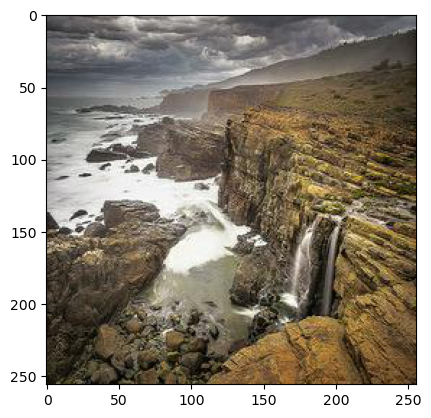

In [10]:
photo_image = plt.imread(photo_path+"/"+next(iter(os.listdir(photo_path))))
plt.imshow(photo_image)

In [11]:
monet_images.shape

(300, 3, 256, 256)

In [12]:
real_images[:300].shape

(300, 3, 256, 256)

In [13]:
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [21]:
batch_size = 10
class Gan_Dataset(Dataset):
    def __init__(self,monet,real):
        self.monet_images = torch.from_numpy(monet_images.astype(np.float32)).to(device)
        self.real_images = torch.from_numpy(real_images[:300].astype(np.float32)).to(device)

    def __len__(self):
        return len(self.monet_images)

    def __getitem__(self, idx):
        return self.monet_images[idx],self.real_images[idx]

dataset = Gan_Dataset(monet_images,real_images)
dataloader = DataLoader(dataset,batch_size = batch_size,shuffle = True)
print("the number of batch is ", len(dataloader))

the number of batch is  30


In [22]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        channel,height,width = monet_image_size[-1],monet_image_size[0],monet_image_size[1]
        self.hidden0 = nn.Sequential(
            nn.Conv2d(in_channels=channel,out_channels=64,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Conv2d(64,128,4,2,1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Conv2d(128,256,4,2,1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden3 = nn.Sequential(
            nn.Conv2d(256,512,4,2,1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            nn.Linear(16*16*512,1),
            nn.Sigmoid())


    def forward(self,x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = x.flatten(start_dim = 1)
        x = self.out(x)
        return x

discriminator_A = Discriminator().to(device)
discriminator_B = Discriminator().to(device)

In [23]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_features, in_features, 3,1,2),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )
        self.out = nn.ReLU()

    def forward(self, x):
        return self.out(x + self.block(x))


class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        channel,height,width = monet_image_size[-1],monet_image_size[0],monet_image_size[1]

        self.hidden0 = nn.Sequential(
            nn.Conv2d(in_channels=channel,out_channels=64,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Conv2d(64,128,4,2,1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Conv2d(128,256,4,2,1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden3 = ResidualBlock(256)
        self.hidden4 = ResidualBlock(256)

        self.hidden5 = nn.Sequential(
            nn.ConvTranspose2d(256,128,4,2,1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden6 = nn.Sequential(
            nn.ConvTranspose2d(128,64,4,2,1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            nn.ConvTranspose2d(64,3,4,2,1),
            nn.BatchNorm2d(3),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.hidden4(x)
        x = self.hidden5(x)
        x = self.hidden6(x)
        x = self.out(x)
        return x
generator_A_to_B = Generator().to(device)
generator_B_to_A = Generator().to(device)

In [24]:
d_a_optimizer = torch.optim.Adam(discriminator_A.parameters(), lr=0.0002)
g_ab_optimizer = torch.optim.Adam(generator_A_to_B.parameters(), lr=0.0002)
d_b_optimizer = torch.optim.Adam(discriminator_B.parameters(), lr=0.0002)
g_ba_optimizer = torch.optim.Adam(generator_B_to_A.parameters(), lr=0.0002)

criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.MSELoss()
criterion_identity = torch.nn.MSELoss()

In [25]:
def ones_target(size):
    return torch.ones(size, 1).to(device)

def zeros_target(size):
   return torch.zeros(size, 1).to(device)

In [ ]:
num_epoch = 10
d_errors = []
g_errors = []

for epoch in range(num_epoch):

  # discriminator.train()
  # generator.train()
  generator_A_to_B.train()
  generator_B_to_A.train()
  discriminator_A.train()
  discriminator_B.train()
  for n_batch, (monet_image, real_image) in enumerate(dataloader):
    N = monet_image.size(0)
    fake_monet = generator_A_to_B(real_image)
    fake_image = generator_B_to_A(monet_image)
    # discriminator_A training
    loss_real_A = criterion_GAN(discriminator_A(real_image),ones_target(N))
    loss_fake_A = criterion_GAN(discriminator_A(fake_image),zeros_target(N))
    loss_D_A = (loss_real_A + loss_fake_A)/2
    loss_D_A.backward()
    d_a_optimizer.step()

    # discriminator_B training
    loss_real_B = criterion_GAN(discriminator_B(monet_image),ones_target(N))
    loss_fake_B = criterion_GAN(discriminator_B(fake_monet),zeros_target(N))
    loss_D_B = (loss_real_B + loss_fake_B)/2
    loss_D_B.backward()
    d_b_optimizer.step()

    loss_D = (loss_D_A + loss_D_B)/2
    d_errors.append(loss_D.cpu().detach().numpy())
    # generator train

    g_ab_optimizer.zero_grad()
    g_ba_optimizer.zero_grad()
    # Identity loss
    loss_id_A = criterion_identity(generator_B_to_A(monet_image),monet_image)
    loss_id_B = criterion_identity(generator_A_to_B(real_image),real_image)
    loss_identity = (loss_id_A + loss_id_B)/2
    #Gan loss

    loss_GAN_AB = criterion_GAN(discriminator_B(fake_monet),ones_target(N))
    loss_GAN_BA = criterion_GAN(discriminator_A(fake_image),ones_target(N))
    loss_GAN = (loss_GAN_AB + loss_GAN_BA)/2

    #Recover loss
    recov_A = generator_B_to_A(fake_monet)
    recov_B = generator_A_to_B(fake_image)
    loss_cycle_A = criterion_cycle(recov_A,real_image)
    loss_cycle_B = criterion_cycle(recov_B, monet_image)

    loss_cycle = (loss_cycle_A + loss_cycle_B)/2

    loss_G = loss_GAN + (10.0*loss_cycle) + (5.0*loss_identity)
    loss_G.backward()
    g_errors.append(loss_G.cpu().detach().numpy())
    g_ab_optimizer.step()
    g_ba_optimizer.step()


    if n_batch%10 == 0:
         print("The",str(n_batch+1),"batch completed.")
         print("The loss for discriminator is ",loss_D.item())
         print("The loss for generator is ",loss_G.item())
  print("The",str(epoch+1),"epoch completed.")

In [ ]:
plt.plot(d_errors,linestyle = "-",label = "discriminator")
plt.plot(g_errors,linestyle = "-",label = "generator")
plt.legend()

In [ ]:
plt.imshow(real_images[0].reshape(monet_image_size))

In [ ]:
# test_example = (real_images[0] - image_mean)/image_std
generator.eval()
test_example = np.random.normal(size = 196608)
test_example = torch.from_numpy(test_example.astype(np.float32)).to(device)
result = generator(test_example).cpu().detach().numpy()
result = (result*image_std+image_mean).astype(int)
plt.imshow(result.reshape(monet_image_size))